# Qubit Rotation with JAX

In this notebook, we shall investigate how we can use simple gradient descent to optimize for the a qubit rotation. The idea is as follows: We start in $|1 \rangle$ state on a Bloch Sphere and apply rotations around Z-Y-Z axes (in that order), each of the three with angles $\phi$, $\theta$, and $\omega$ respectively

$R(\phi,\theta,\omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
\end{bmatrix}$

to reach the target state, which is defined to be $|0 \rangle$ in this case.

In [16]:
import jax.numpy as jnp
import numpy as onp
from qutip import *
from jax import grad, jit
from jax.random import normal, PRNGKey

In [27]:
def rot(phi, theta, omega):
    """Returns a rotation matrix describing rotation around Z-Y-Z axis
    
    Parameters:
    ----------
        phi: int/float 
             rotation angle for the second rotation around z axis 
             
        theta: int/float
             rotation angle around y axis
             
        omega: int/float
             rotation angle for the first rotation around z axis
        
    Returns:
    --------
        rm: array[complex]
             array representing the rotation matrix 
    """
    
    cos = jnp.cos(theta/2)
    sin = jnp.sin(theta/2)

    return jnp.array(
    [
        [jnp.exp(-0.5j*(phi+omega))*cos, -(jnp.exp(0.5j*(phi-omega)))*sin],
        [jnp.exp(-0.5j*(phi-omega))*sin, jnp.exp(0.5j*(phi+omega))*cos],
        
    ]
    )


def cost(phi, theta, omega, ket):
    r"""Returns the fidelity between the evolved state and :math: `|0 \rangle` state
    
    Parameters:
    ----------
        phi: int/float 
             rotation angle for the second rotation around z axis 
             
        theta: int/float
             rotation angle around y axis
             
        omega: int/float
             rotation angle for the first rotation around z axis
             
        ket: array[complex] 
             array representing the ket to be acted upon by by the rotation matrix

    Returns:
    -------
        float: 
        fidelity between the :math:`|0 \rangle` state and the evolved state under rotation    
    """
    
    evolved = jnp.dot(rot(phi, theta, omega), ket)
    return jnp.absolute(jnp.vdot(evolved.T,basis(2,0).full()))


## Gradient Descent Implementation 

Here we have our own gradient descent implementation. There are multiple paramters, like `epochs`, `alpha`, etc, that one might tune further in hopes of better convergence. For our purposes, however, we see that our implementation converges well in a little less than 100 steps. 

In [101]:
#initialize parameters for descent
epochs = 100
alpha = 0.1 #learning rate
tol = 1e-7
diff = 1 # diff of new and prev weights should be less than diff
max_iters = 1
iters = 0
key = PRNGKey(0) #Generate a PRNG key
weights = normal(key=key, shape=(3,))
init_ket = basis(2,1).full()
der_cost = grad(cost, argnums = [0,1,2])

for epoch in range (epochs):
    iters = 0
    diff = 1
    tol = 1e-7
    while jnp.all(diff > tol) and iters < max_iters:
        prev_weights = weights
        der = jnp.asarray(der_cost(*prev_weights.T,init_ket))
        weights = weights + alpha*der
        iters += 1
        diff = jnp.absolute(weights-prev_weights)
    fidel = cost(*weights.T, init_ket)
    progress = [epoch+1, fidel]
    if ((epoch)%1==0):
        print("Epoch: {:2f} | Fidelity: {:3f}".format(*jnp.asarray(progress)))

Epoch: 1.000000 | Fidelity: 0.262476
Epoch: 2.000000 | Fidelity: 0.285675
Epoch: 3.000000 | Fidelity: 0.308551
Epoch: 4.000000 | Fidelity: 0.331081
Epoch: 5.000000 | Fidelity: 0.353247
Epoch: 6.000000 | Fidelity: 0.375028
Epoch: 7.000000 | Fidelity: 0.396410
Epoch: 8.000000 | Fidelity: 0.417375
Epoch: 9.000000 | Fidelity: 0.437910
Epoch: 10.000000 | Fidelity: 0.458004
Epoch: 11.000000 | Fidelity: 0.477645
Epoch: 12.000000 | Fidelity: 0.496825
Epoch: 13.000000 | Fidelity: 0.515535
Epoch: 14.000000 | Fidelity: 0.533771
Epoch: 15.000000 | Fidelity: 0.551528
Epoch: 16.000000 | Fidelity: 0.568802
Epoch: 17.000000 | Fidelity: 0.585592
Epoch: 18.000000 | Fidelity: 0.601898
Epoch: 19.000000 | Fidelity: 0.617720
Epoch: 20.000000 | Fidelity: 0.633060
Epoch: 21.000000 | Fidelity: 0.647921
Epoch: 22.000000 | Fidelity: 0.662308
Epoch: 23.000000 | Fidelity: 0.676225
Epoch: 24.000000 | Fidelity: 0.689677
Epoch: 25.000000 | Fidelity: 0.702672
Epoch: 26.000000 | Fidelity: 0.715217
Epoch: 27.000000 | Fi

## Bloch Sphere Visualization

We see that started off with a very low fidelity. With gradient descent iterations, we progressively achieve better fidelities via better parameters,$\phi$, $\theta$, and $\omega$. To see it visually, we render our states on to a Bloch sphere.

On a Bloch sphere below, we started with $|1 \rangle$ state (green arrow) and the optimized parameters of the rotation matrix give us our desired $R(\phi,\theta,\omega)$ such that $R(\phi,\theta,\omega) |1 \rangle$ evolves the state $|1 \rangle$ to the state represented by the brown arrow, which is very close to our target state, $|0 \rangle$ (blue arrow), as desired.

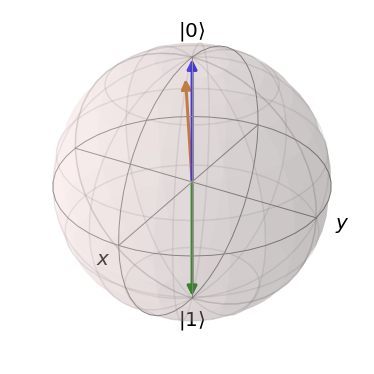

In [103]:
b = Bloch()
b.add_states(Qobj(init_ket))
final = Qobj(onp.dot(rot(*weights), init_ket))
b.add_states(final)
b.add_states(basis(2,0))
b.show()